In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
%tensorflow_version 2.x

In [3]:
# tf.__version__ # 2.8.0

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [6]:
# read the dataset
df = pd.read_csv('/content/MyDrive/MyDrive/datasets/cleanedsentiment.csv')

In [7]:
df.head()

,sentiment,tweet
0,0,drop iphone work look replacement
1,0,feel c y day
2,4,heycassadee malaysia far away japan
3,4,fold clothe mommy ethan turn toss ethan pile c...
4,4,accomplish


In [8]:
df.shape

(320000, 2)

In [9]:
df.isnull().sum()

sentiment      0
tweet        381
dtype: int64

In [10]:
# there are 381 tweets with NaN value we need to remove them
df.dropna(how='any', inplace=True)

In [11]:
df.shape

(319619, 2)

In [12]:
df['sentiment'].unique()

array([0, 4])

In [13]:
# as there are 2 outputs i.e 0 for negative and 4 for positive
# need to change postive 4 representation to 1
df['sentiment'] = df['sentiment'].astype('bool').astype('int8')

In [14]:
df.head()

,sentiment,tweet
0,0,drop iphone work look replacement
1,0,feel c y day
2,1,heycassadee malaysia far away japan
3,1,fold clothe mommy ethan turn toss ethan pile c...
4,1,accomplish


In [15]:
# there are 2 ways to get model for sentiment 
# 1.) Using TF-IDF Vectorizer
# 2.) Using BERT Model (i.e Neural Networks)
# I am going to use Neural Networks methos to learn BERT implementation (Hope so, it works fine)

In [16]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 32.4 MB/s 
     |████████████████████████████████| 596 kB 44.5 MB/s 
     |████████████████████████████████| 895 kB 43.2 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [17]:
from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
bertmodel = TFAutoModel.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['classifier', 'dropout_19', 'pre_classifier']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [18]:
# save bert model and tokenizer for futureuse
tokenizer.save_pretrained('bert-tokenizer', do_lower_case=True)
bertmodel.save_pretrained('bert-model')

In [19]:
!zip -r /content/bert-model.zip /content/bert-model/

  adding: content/bert-model/ (stored 0%)
  adding: content/bert-model/config.json (deflated 45%)
  adding: content/bert-model/tf_model.h5 (deflated 8%)


In [20]:
!zip -r /content/bert-tokenizer.zip /content/bert-tokenizer/

  adding: content/bert-tokenizer/ (stored 0%)
  adding: content/bert-tokenizer/vocab.txt (deflated 53%)
  adding: content/bert-tokenizer/tokenizer.json (deflated 71%)
  adding: content/bert-tokenizer/special_tokens_map.json (deflated 40%)
  adding: content/bert-tokenizer/tokenizer_config.json (deflated 42%)


In [21]:
# from google.colab.files import download
# download("/content/bert-tokenizer.zip")
# download("/content/bert-model.zip")

In [22]:
tokenizer('My Name is Deepak. I want to pursue my career as Jr Data Scientist.')

{'input_ids': [101, 2026, 2171, 2003, 2784, 4817, 1012, 1045, 2215, 2000, 7323, 2026, 2476, 2004, 3781, 2951, 7155, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [23]:
# split dataset into train and test with stratification to avoid learning issues

In [24]:
X, Y = df['tweet'], df['sentiment']

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, stratify=Y, test_size=0.1, random_state=2022)

In [27]:
# The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't

In [28]:
Xtrain_bert = tokenizer(text = Xtrain.tolist(),
                        add_special_tokens = True,
                        max_length = 50,
                        truncation = True,
                        padding = True,
                        return_tensors = 'tf',
                        return_attention_mask = True,
                        return_token_type_ids = False,
                        verbose = True)

In [29]:
Xtest_bert = tokenizer(text = Xtest.tolist(),
                        add_special_tokens = True,
                        max_length = 50,
                        truncation = True,
                        padding = True,
                        return_tensors = 'tf',
                        return_attention_mask = True,
                        return_token_type_ids = False,
                        verbose = True)

In [30]:
max_length = 50

In [31]:
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')

In [32]:
input_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

In [33]:
embeddings = bertmodel(input_ids, attention_mask = input_masks)[0]

In [34]:
output = tf.keras.layers.GlobalMaxPool1D()(embeddings)

In [35]:
output = tf.keras.layers.Dense(128, activation='relu')(output)

In [36]:
output = tf.keras.layers.Dropout(0.1)(output)

In [37]:
output = tf.keras.layers.Dense(64, activation='relu')(output)

In [38]:
y = tf.keras.layers.Dense(2, activation='sigmoid')(output)

In [39]:
model = tf.keras.Model(inputs=[input_ids, input_masks], outputs = y)

In [40]:
model.layers[2].trainable = True

In [41]:
# set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5,
                                     epsilon = 1e-8,
                                     decay = 0.01,
                                     clipnorm = 1.0)

In [42]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False)

In [43]:
metrics = tf.keras.metrics.CategoricalAccuracy('balanced_accuracy')

In [44]:
model.compile(optimizer = optimizer,
               loss = loss,
               metrics = metrics)

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 50, 768),                                                    
                                 hidden_states=None                                           

In [46]:
history = model.fit(x = {
                        'input_ids' : Xtrain_bert['input_ids'],
                        'attention_mask' : Xtrain_bert['attention_mask']
                    },
                    y = tf.keras.utils.to_categorical(Ytrain),
                    validation_data = ({
                                        'input_ids' : Xtest_bert['input_ids'],
                                        'attention_mask' : Xtest_bert['attention_mask']
                                    },
                                    tf.keras.utils.to_categorical(Ytest)),
                     epochs = 1,
                     batch_size = 64,
                     use_multiprocessing = True
                     )

4495/4495 [==============================] - 2942s 651ms/step - loss: 0.5426 - balanced_accuracy: 0.7241 - val_loss: 0.5252 - val_balanced_accuracy: 0.7386


In [47]:
model.save_weights('custom_model')

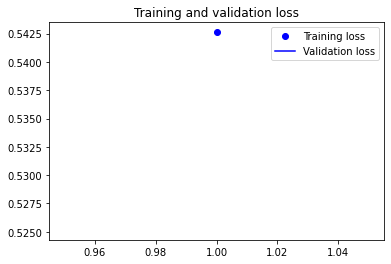

In [48]:
epochs = range(1, len(history.history['loss']) + 1)
plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [49]:
# prediction part
Ypred = model.predict({ 'input_ids' : Xtest_bert['input_ids'],
                       'attention_mask' : Xtest_bert['attention_mask']
                       })

In [50]:
Ypred = np.argmax(Ypred, axis = 1)

In [51]:
from sklearn.metrics import classification_report

In [52]:
print(classification_report(Ytest, Ypred))

              precision    recall  f1-score   support

           0       0.76      0.71      0.73     15977
           1       0.72      0.77      0.75     15985

    accuracy                           0.74     31962
   macro avg       0.74      0.74      0.74     31962
weighted avg       0.74      0.74      0.74     31962



In [55]:
model.save_weights('custom_model/custom_model')

In [56]:
!zip -r /content/custom_model.zip /content/custom_model/

  adding: content/custom_model/ (stored 0%)
  adding: content/custom_model/custom_model.data-00000-of-00001 (deflated 16%)
  adding: content/custom_model/custom_model.index (deflated 80%)
  adding: content/custom_model/checkpoint (deflated 41%)
